In [ ]:
!pip install -q tensorflow_text

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/multilabel/train.csv", index_col="id")

In [ ]:
df

,keyword,user,text,target
id,,,,
0,fire,Traffic_ZMG,"Fire in a garbage dump in Matatlán, we ask @PC...",2
1,traffic light,Traffic_ZMG,Broken traffic light at the intersection of Sa...,3
2,fire,Traffic_ZMG,#ReporteZMG A vehicle caught fire on Calderón ...,2
3,fire,Traffic_ZMG,ð¨ #NoticiaZMG A voracious fire devastated a...,2
4,traffic accident,Traffic_ZMG,Fatal crash occurred on the highway to Los Alt...,1
...,...,...,...,...
5995,fire,Traffic_ZMG,"@lacomadreja23 Good morning, it was a fire",2
5996,fire,Traffic_ZMG,"Strong fire in Fire in La Magdalena Jalisco, t...",2
5997,fire,Traffic_ZMG,ð¥ð³ Grassland fire on land located on the...,2


In [ ]:
num_classes = len(df["keyword"].value_counts())

In [ ]:
df["target"] = df["keyword"].map({"traffic accident": 0,
                                  "fire": 1,
                                  "traffic light": 2})
df = df.drop(columns=["keyword", "user"])
df.head(10)

,text,target
id,,
0,"Fire in a garbage dump in Matatlán, we ask @PC...",1
1,Broken traffic light at the intersection of Sa...,2
2,#ReporteZMG A vehicle caught fire on Calderón ...,1
3,ð¨ #NoticiaZMG A voracious fire devastated a...,1
4,Fatal crash occurred on the highway to Los Alt...,0
5,@JaliscoVial Collision between a MacroPeribus ...,0
6,At the intersection of CosÃo Vidaurri and Jard...,1
7,Accident between vehicles on Manuel Ávila Cama...,2
8,Broken traffic light at the intersection of Al...,2


In [ ]:
y = tf.keras.utils.to_categorical(df["target"].values, num_classes=num_classes)
x_train, x_test, y_train, y_test = train_test_split(df["text"], y, test_size=0.20)

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/2")


In [ ]:
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
n_epochs = 20

METRICS = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
           balanced_recall,
           balanced_precision, balanced_f1_score
           ]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=3,
                                                      restore_best_weights=True)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=METRICS)

model_fit = model.fit(x_train,
                      y_train,
                      epochs=n_epochs,
                      validation_data=(x_test, y_test),
                      callbacks=[earlystop_callback])

Epoch 1/20
150/150 [==============================] - 68s 360ms/step - loss: 0.8073 - accuracy: 0.6510 - balanced_recall: 0.4834 - balanced_precision: 0.7252 - balanced_f1_score: 0.5728 - val_loss: 0.5475 - val_accuracy: 0.8433 - val_balanced_recall: 0.7575 - val_balanced_precision: 0.9096 - val_balanced_f1_score: 0.8251
Epoch 2/20
150/150 [==============================] - 51s 340ms/step - loss: 0.5098 - accuracy: 0.8304 - balanced_recall: 0.7558 - balanced_precision: 0.8818 - balanced_f1_score: 0.8123 - val_loss: 0.4205 - val_accuracy: 0.8750 - val_balanced_recall: 0.8377 - val_balanced_precision: 0.9207 - val_balanced_f1_score: 0.8760
Epoch 3/20
150/150 [==============================] - 57s 381ms/step - loss: 0.4178 - accuracy: 0.8646 - balanced_recall: 0.8174 - balanced_precision: 0.8985 - balanced_f1_score: 0.8552 - val_loss: 0.3700 - val_accuracy: 0.8867 - val_balanced_recall: 0.8567 - val_balanced_precision: 0.9227 - val_balanced_f1_score: 0.8878
Epoch 4/20
150/150 [===========

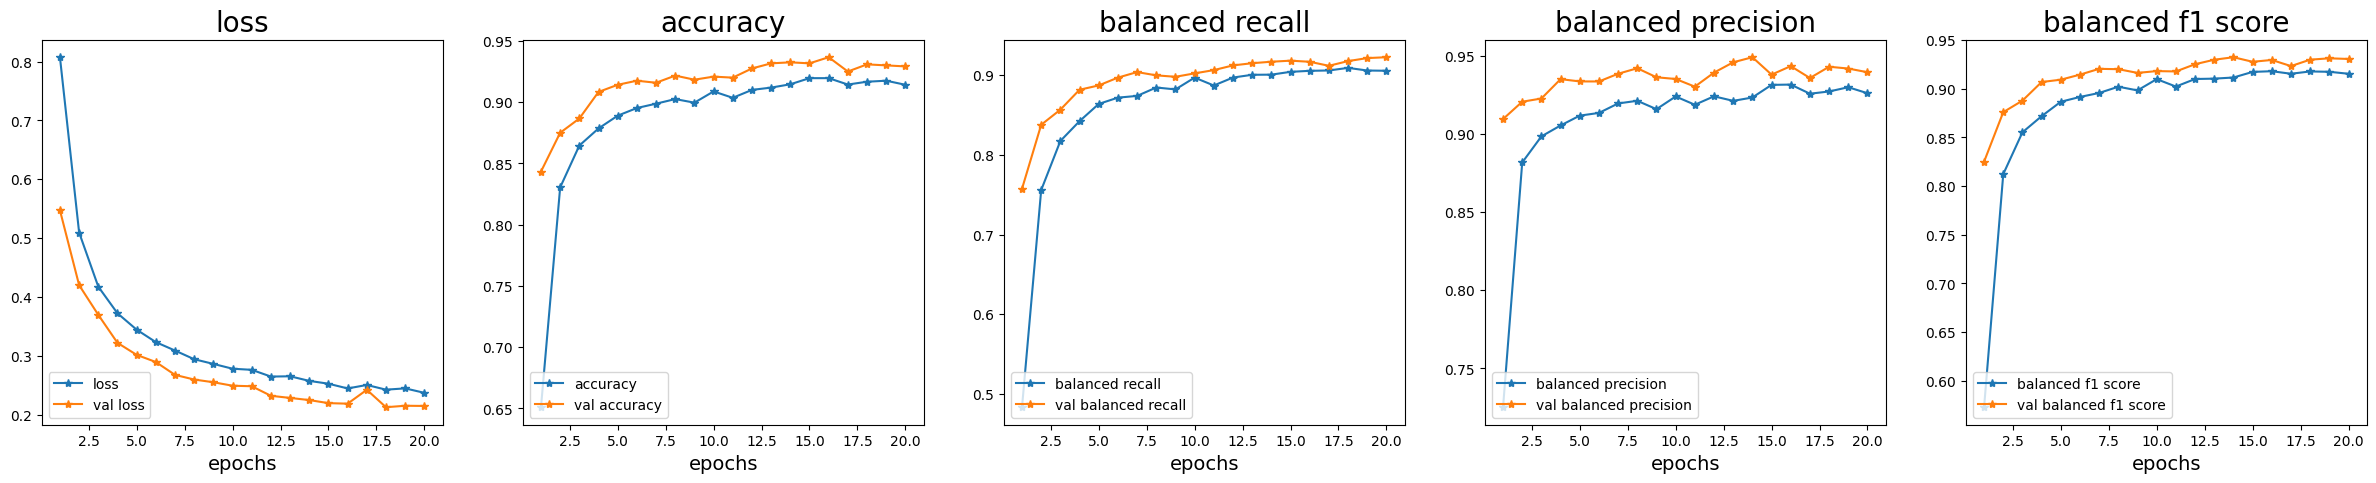

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="*", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="*", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
pred_list = ['Collapsed traffic from Zapopan Centro Cemetery to Periférico at Plaza Belenes, take precautions when driving through the area ???????? #ReporteZMG https://t.co/PsC5eocpro',
             'Fire at the height of Preparatory School No. 20 UdeG, on Paso del Bosque Avenue, in the El Fortín neighborhood.We ask @UMPCyBZ to attend to the report as soon as possible. #ReporteZMG',
             'Traffic light not working at the intersection of Cristobal Colon Avenue and Paseo de los Balcones Street, in the Cerro del Tesoro neighborhood in Tlaquepaque 🚥 We ask @AgenciaAMIM and @JaliscoVial to attend to the report. #ReporteZMG https://t.co/EKTvFvo5Gt',
             'Heavy collision between public transportation unit and private vehicle on Calderón de la Barca Street and José María Morelos Avenue #ReporteZMG https://t.co/QIDC6aPMFw',
             'A vehicle caught fire on Mariano Otero Avenue, near Expo Guadalajara, in the direction of López Mateos Avenue. The incident has been controlled, however, the roadway has a lot of traffic in both directions.',
             'Traffic light obstructed by tree leaves at the intersection of Franciscode Ayza and Felipe Ángeles streets.']

In [ ]:
def predict_class(accidents):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(accidents)]


In [ ]:
predict_class(pred_list)

1/1 [==============================] - 1s 964ms/step


[0, 1, 2, 0, 0, 2]

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/Datasets/multilabel/test.csv", index_col="id")

In [ ]:
test = test.drop(columns=["user"])
test.head(10)

,keyword,text
id,,
0,fire,"Fire in a garbage dump in Matatlán, we ask @PC..."
1,traffic light,Broken traffic light at the intersection of Sa...
2,fire,#ReporteZMG A vehicle caught fire on Calderón ...
3,fire,ð¨ #NoticiaZMG A voracious fire devastated a...
4,traffic accident,Fatal crash occurred on the highway to Los Alt...
5,traffic accident,@JaliscoVial Collision between a MacroPeribus ...
6,fire,At the intersection of CosÃo Vidaurri and Jard...
7,traffic light,Accident between vehicles on Manuel Ávila Cama...
8,traffic light,Broken traffic light at the intersection of Al...


In [ ]:
from sklearn.metrics import classification_report

y_pred = predict_class(df["text"])
print(classification_report(df["target"], y_pred))

188/188 [==============================] - 47s 252ms/step
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2000
           1       0.96      0.93      0.94      2000
           2       0.94      0.94      0.94      2000

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [ ]:
model.save('/content/drive/MyDrive/Models/BERT_Model_MultiClass.h5')